# FlashAttention 详解：背景、原理、实现与现状

本 Notebook 将详细介绍 [FlashAttention](https://arxiv.org/abs/2205.14135) 技术，帮助初学者理解它是如何解决 Transformer 性能瓶颈的。  
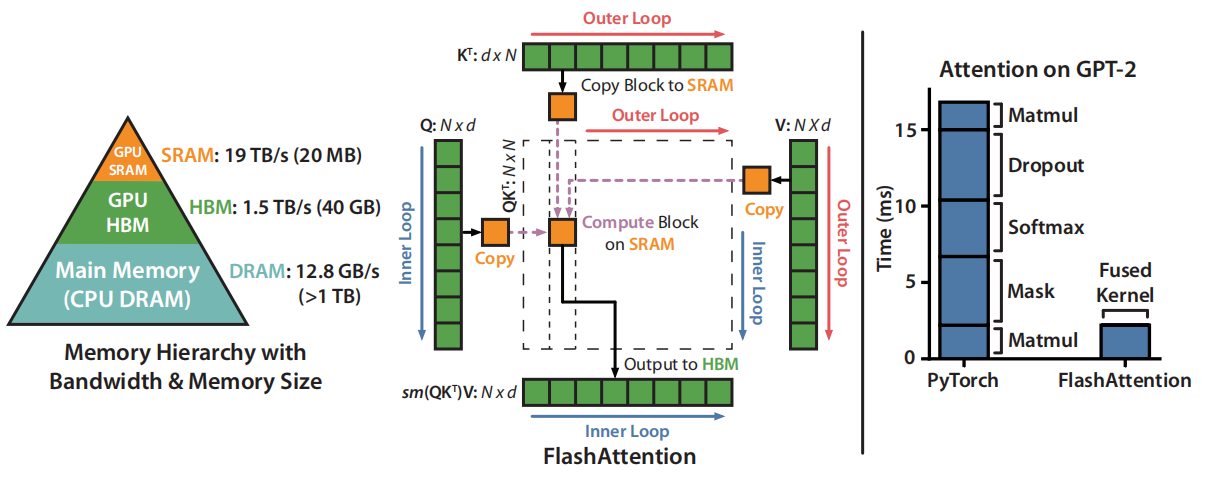

## 1. 诞生的背景 (Background)
### 1.1 CUDA的计算
要理解FlashAttention，首先需要了解数据在CUDA kernel 中的计算流程。  
- **HBM (High Bandwidth Memory)**: GPU 的主显存（如 A100 的 40GB/80GB 显存），容量大但读写速度相对较慢。
- **SRAM (On-chip Memory)**: GPU 计算单元附近的缓存，读写速度极快（比 HBM 快一个数量级），但容量非常小。
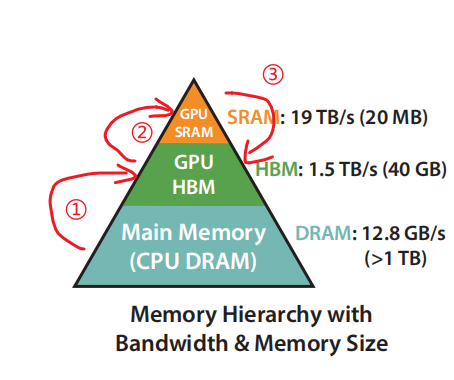  
数据的完整计算流程如下：  
+ 第一步：数据和模型先从CPU的DRAM（内存）加载到GPU的VRAM（显存）中；
+ 第二步：数据从HBM加载到GPU的SRAM（缓存）中,CUDA kernel 在SRAM中对这些数据进行计算；
+ 第三步：计算完成后，将结果从SVRAM中写回到HBM中。  
  
FlashAttention的核心思想是减少数据在HBM和SRAM之间（②和③）的传输次数，从而提高计算效率。

### 1.2 标准 Attention 的计算
标准的 Attention 计算公式为：
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$
其中 $Q, K, V$ 的形状通常为 $(N, d)$，其中 $N$ 是序列长度，$d$ 是隐藏层维度。  
我们首先来总结一下公式中涉及到的3次矩阵运算：  
- $S = QK^T$：计算 $N \times N$ 的相似度矩阵 $S$，需要 $O(N^2 d)$ 次乘法和 $O(N^2)$ 次加法。
- $\text{softmax}(S)$：对 $S$ 进行 Softmax 归一化，需要 $O(N^2)$ 次计算。
- $O = PV$：计算 $N \times d$ 的输出矩阵 $O$，需要 $O(N^2 d)$ 次乘法和 $O(N d)$ 次加法。  

**标准 Attention 的痛点**： 
在计算 $S = QK^T$、计算 Softmax、计算 $P = \text{softmax}(S)$、计算 $O = PV$ 的过程中，标准实现需要频繁地将庞大的 $N \times N$ 矩阵在 HBM 和 SRAM 之间搬运。这种频繁的 **IO (输入输出) 操作** 消耗了大量时间，导致 GPU 的计算单元经常处于“等待数据”的状态。  
这一过程中，数据在 HBM 和 SRAM 之间的传输次数是6次，FlashAttention将6次传输减少到了2次。

## 2. 实现的原理 (Principle)

FlashAttention 的核心思想是 **IO-Aware (IO感知)**，即在算法设计层面显式地优化 GPU 内存层级的访问。它主要通过两大技术实现：**Tiling (分块)** 和 **Recomputation (重计算)**。

### 2.1 Tiling (分块计算)
为了支持 $N$ 较大的情况（如 $N=2048$甚至更长），但避免在SRAM中存储完整的 $N \times N$ 矩阵，$Q, K, V$ 矩阵切分成小的 **Block (块)**。

1.  **加载到 SRAM**：每次只将一小块 $Q$ 和 $K, V$ 加载到高速的 SRAM 中。
2.  **SRAM 内计算**：在 SRAM 内部完成矩阵乘法 ($QK^T$) 和 Softmax 的局部计算。
3.  **Online Softmax**：利用 Online Softmax 技巧，允许在未读取完整行的情况下，通过维护局部最大值和归一化因子，逐步更新最终的 Attention 结果。
4.  **写回 HBM**：只将最终计算好的 Output 块写回 HBM，中间庞大的 Attention 矩阵从未在 HBM 中完整实例化。

### 2.2 Recomputation (重计算)
在神经网络的反向传播 (Backward) 中，计算梯度通常需要前向传播时的中间激活值（这里指 Attention Matrix）。

- **标准做法**：在前向传播时，将巨大的 $N \times N$ Attention Matrix 保存到 HBM 中，供反向传播使用。这极其消耗显存。
- **FlashAttention 做法**：**不保存** Attention Matrix。在反向传播时，利用保存的 $Q, K, V$ 和前向计算时统计的归一化因子，在 SRAM 中快速**重新计算**出需要的 Attention 块。

虽然“重计算”增加了 FLOPs（浮点运算量），但由于减少了最慢的 HBM 读写操作，总体速度反而更快，且显存占用从 $O(N^2)$ 降低到了 $O(N)$（线性）。

## 3. 实例代码 (Code Example)

下面的代码展示了三个部分：
1.  **Standard Attention**: 标准的 PyTorch 实现。
2.  **Simulated FlashAttention**: 一个用 Python 模拟 FlashAttention 分块逻辑的简化版本（用于理解原理，实际 FlashAttention 是用 CUDA/Triton 编写的底层 Kernel）。
3.  **PyTorch SDPA**: 使用 PyTorch 2.0+ 内置的 `scaled_dot_product_attention`，它会自动调用 FlashAttention 加速。

Using CUDA
1. Running Standard Attention...
2. Running Simulated Flash Attention...
3. Running PyTorch SDPA (FlashAttention Backend)...

Max Difference (Standard vs Simulated): 0.000000
Max Difference (Standard vs Flash): 0.000000

结论：模拟实现和标准实现的输出几乎一致，证明了分块算法的正确性。


## 4. 当前的发展情况 (Current Status)

FlashAttention 已经成为大模型时代的“基础设施”，几乎所有主流 LLM 都在使用。

### 4.1 版本演进
- **FlashAttention-1 (2022)**: 提出了 IO-Aware 算法，比标准 Attention 快 2-4 倍，显存占用线性降低。
- **FlashAttention-2 (2023)**: 
    - 优化了并行策略（增加 Sequence Length 维度的并行）。
    - 减少了非矩阵乘法（Non-matmul）运算。
    - 针对 NVIDIA Hopper (H100) 架构进行了优化。
    - 速度相比 v1 提升约 2 倍，达到理论峰值 FLOPs 的 50%-73%。
- **FlashAttention-3 (2024)**: 
    - 进一步挖掘 H100 潜力，支持 FP8 低精度训练。
    - 实现了 GEMM 和 Softmax 的重叠执行 (Overlapping)，进一步掩盖内存延迟。

### 4.2 生态集成
- **PyTorch**: 从 PyTorch 2.0 开始，`torch.nn.functional.scaled_dot_product_attention` (SDPA) 默认集成了 FlashAttention。当检测到 GPU 支持且数据类型符合要求（通常是 fp16/bf16）时，会自动启用。
- **HuggingFace Transformers**: 现已全面支持。在加载模型时使用 `attn_implementation="flash_attention_2"` 即可开启。
- **LLM 训练框架**: DeepSpeed, Megatron-LM, MosaicML 等均默认集成。

### 4.3 带来的影响
FlashAttention 最直接的贡献是让 **长上下文 (Long Context)** 成为可能。正是因为有了它，我们才能看到支持 32k, 128k 甚至 1M Token 上下文的模型（如 GPT-4 Turbo, Claude 3, Moonshot 等）涌现。